# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

from tqdm import tqdm
from itertools import combinations


# Load Data

In [2]:
# df is the non-normalized passive data with features and target 
df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/df_passive_fe.csv')

# mlm_gap_df is the results of the MLM on the gap data
mlm_gap_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_gap_results_df.csv')
mlm_affect_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_affect_results_df.csv')

## Train-Test Split

Perform train-test split based on the last day of data collection where a subject had 
data for the SensorKit (based on unlock duration data)

In [3]:
# Get last day of data collection for each PID based on unlock duration data
last_days = df.groupby('PID').agg({
    'day': lambda x: x[df['passive_sk_device_total_unlock_duration'].notna()].max()
}).reset_index()

# Remove any data after each PID's last day
tt_filtered = pd.merge(
    df,
    last_days,
    on='PID',
    suffixes=('', '_last')
)
tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]

# Create train/test splits for each PID
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for pid in tt_filtered['PID'].unique():
    pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
    
    # Sort by day to ensure chronological split
    pid_data = pid_data.sort_values('day')
    
    # Calculate split point at 80%
    split_idx = int(len(pid_data) * 0.8)
    
    # Split the data
    train_pid = pid_data.iloc[:split_idx]
    test_pid = pid_data.iloc[split_idx:]
    
    # Append to main dataframes
    train_data = pd.concat([train_data, train_pid])
    test_data = pd.concat([test_data, test_pid])

# Reset indices
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Number of unique PIDs in training: {train_data['PID'].nunique()}")
print(f"Number of unique PIDs in test: {test_data['PID'].nunique()}")

Training set size: 5141
Test set size: 1350
Number of unique PIDs in training: 105
Number of unique PIDs in test: 105


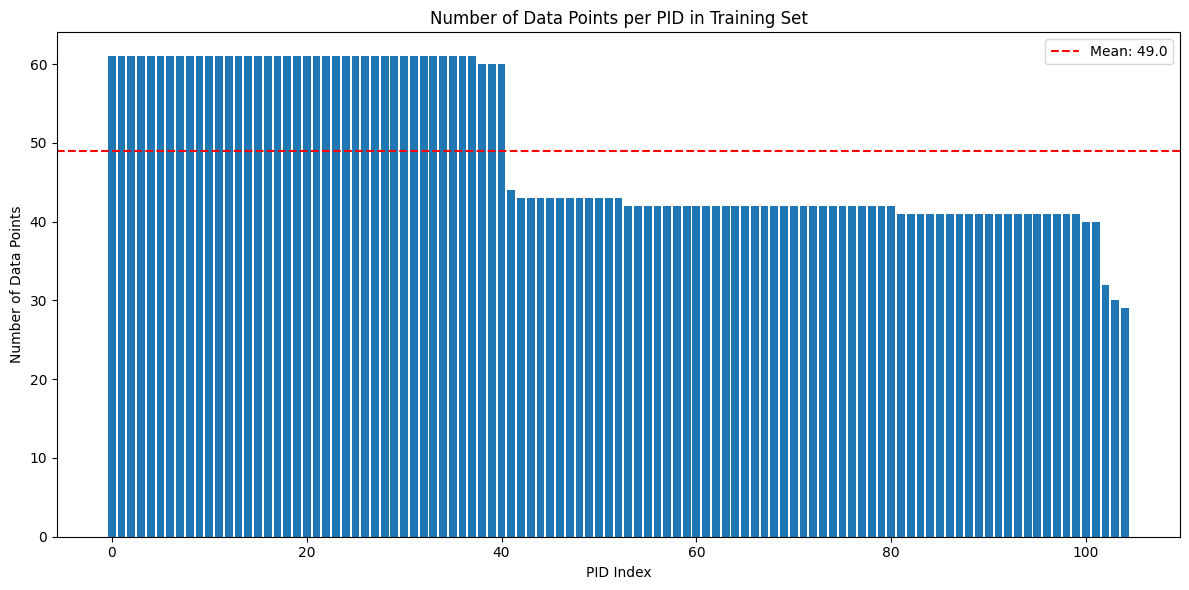

In [4]:
# Count data points per PID in training set
pid_counts = train_data['PID'].value_counts()

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(pid_counts)), pid_counts.values)
plt.xlabel('PID Index')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per PID in Training Set')

# Add mean line
mean_points = pid_counts.mean()
plt.axhline(y=mean_points, color='r', linestyle='--', label=f'Mean: {mean_points:.1f}')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [5]:
# Check for empty, binary (0/1) columns and non-numeric columns
empty_cols = []
binary_cols = []
non_numeric_cols = []

for col in train_data.columns:
    # Check if column is empty (all NaN)
    if train_data[col].isna().all():
        empty_cols.append(col)
        continue
        
    # Check if column is non-numeric
    if not np.issubdtype(train_data[col].dtype, np.number):
        non_numeric_cols.append(col)
        continue
        
    # Check if column only contains 0s and 1s
    unique_vals = train_data[col].unique()
    unique_vals = unique_vals[~np.isnan(unique_vals)]  # Remove NaN values
    if set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)

print("Empty columns:")
print(empty_cols)
print("\nBinary columns:")
print(binary_cols)
print("\nNon-numeric columns:")
print(non_numeric_cols)


Empty columns:
[]

Binary columns:
['survey_complete', 'tasks_complete', 'watch_wearing', 'weekend', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'fe_lag_1_survey_complete', 'fe_lag_2_survey_complete', 'fe_lag_3_survey_complete', 'fe_lag_1_tasks_complete', 'fe_lag_2_tasks_complete', 'fe_lag_3_tasks_complete', 'fe_lag_1_watch_wearing', 'fe_lag_2_watch_wearing', 'fe_lag_3_watch_wearing']

Non-numeric columns:
['PID', 'trial_date', 'cohort']


# Visualizations

In [6]:
def fit_single_variable_mlm(data, predictor, target='t_current', random_intercepts=False):
    """
    Fit a single variable mixed linear model with random intercepts and/or slopes.
    
    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the predictor, target and PID columns
    predictor : str
        Name of predictor column to use in model
    target : str, default='t_current'
        Name of target column to predict
    random_intercepts : bool, default=False
        Whether to include random intercepts in model
        
    Returns
    -------
    tuple
        Tuple containing (model fit object, AIC, BIC)
    """
    model_data = data[[predictor, target, 'PID']].dropna()
            
    # Filter out participants with less than 10 data points
    group_sizes = model_data.groupby('PID').size()
    valid_pids = group_sizes[group_sizes >= 10].index
    model_data = model_data[model_data['PID'].isin(valid_pids)]

    # Filter out columns with less than 10 subjects
    no_subs = len(np.unique(model_data['PID']))

    # Only proceed if there's enough data
    if len(model_data) > 0 and no_subs >= 10:
        if random_intercepts:
            md = smf.mixedlm(f"{target} ~ 1 + {predictor}",
                model_data,
                groups=model_data["PID"],
                re_formula=f"1 + {predictor}")
        else:
            md = smf.mixedlm(f"{target} ~ 1 + {predictor}",
                model_data,
                groups=model_data["PID"],
                re_formula=f"0 + {predictor}")

        converged = True
        try:
            fit = md.fit(method='nm',
                        maxiter=1000,
                        start_params=None,
                        full_output=True)
                        
            # Calculate AIC and BIC by hand
            n = len(model_data)  # number of observations
            k = len(fit.params)  # number of parameters
            ll = fit.llf  # log likelihood
            
            # AIC = -2ln(L) + 2k
            aic = -2 * ll + 2 * k
            
            # BIC = -2ln(L) + k*ln(n) 
            bic = -2 * ll + k * np.log(n)
            
        except:
            print("Model failed to converge with bfgs")
            try:
                # Try alternate optimizer
                fit = md.fit(method='bfgs',
                            maxiter=1000,
                            full_output=True)
                            
                # Calculate AIC and BIC by hand
                n = len(model_data)
                k = len(fit.params)
                ll = fit.llf
                
                aic = -2 * ll + 2 * k
                bic = -2 * ll + k * np.log(n)
                
            except:
                print(f"Model failed to converge with both optimizers for {predictor}")
                converged = False
                return None, None, None

        # Get fixed effects
        fixed_intercept = fit.fe_params[0]
        fixed_slope = fit.fe_params[1]

        # Get random effects
        random_effects = fit.random_effects

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get slopes for color mapping - Modified to handle both cases
        slopes = []
        for pid in random_effects.keys():
            re = random_effects[pid]
            if random_intercepts:
                # With random intercepts, slope is at index 1
                subj_slope = fixed_slope + re[1]
            else:
                # Without random intercepts, only slope exists at index 0
                subj_slope = fixed_slope + re[0]
            slopes.append(subj_slope)

        # Create colormap based on slopes
        norm = plt.Normalize(min(slopes), max(slopes))
        cmap = plt.cm.viridis

        # Plot individual lines for each subject using their own x range
        for pid, slope in zip(random_effects.keys(), slopes):
            subject_data = model_data[model_data['PID'] == pid]
            x_min = subject_data[predictor].min()
            x_max = subject_data[predictor].max()
            x_range = np.linspace(x_min, x_max, 100)
            
            re = random_effects[pid]
            if random_intercepts:
                subj_intercept = fixed_intercept + re[0]
                subj_slope = fixed_slope + re[1]
            else:
                subj_intercept = fixed_intercept  # Use fixed intercept only
                subj_slope = fixed_slope + re[0]
            y = subj_intercept + subj_slope * x_range
            ax.plot(x_range, y, color=cmap(norm(slope)), alpha=0.5)

        # Plot fixed effects line across full range
        x_range_full = np.linspace(model_data[predictor].min(), model_data[predictor].max(), 100)
        y_fixed = fixed_intercept + fixed_slope * x_range_full
        ax.plot(x_range_full, y_fixed, 'k-', linewidth=3, label='Fixed Effects')

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm, ax=ax, label='Slope')

        ax.set_xlabel(predictor)
        ax.set_ylabel(target)
        title = 'Mixed Effects Model: Random Slopes' if not random_intercepts else 'Mixed Effects Model: Random Intercepts and Slopes'
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        plt.show()
        
        print(f"--------------------------------")
        print(f"AIC: {aic:.4f}")
        print(f"BIC: {bic:.4f}")
        print(f"--------------------------------")
        print(fit.summary())
        # Calculate mean survey completion rates for positive vs negative slope groups
        slopes_df = pd.DataFrame({
            'PID': list(random_effects.keys()),
            'slope': slopes
        })
        
        # Merge with the original data to get survey_complete counts
        slopes_df = slopes_df.merge(
            train_data.groupby('PID')['survey_complete'].sum().reset_index(),
            on='PID'
        )
        
        # Split into positive and negative slope groups
        pos_slope_surveys = slopes_df[slopes_df['slope'] > 0]['survey_complete']
        neg_slope_surveys = slopes_df[slopes_df['slope'] <= 0]['survey_complete']
        
        # Calculate means and confidence intervals
        from scipy import stats
        
        pos_mean = pos_slope_surveys.mean()
        pos_ci = stats.t.interval(
            confidence=0.95,
            df=len(pos_slope_surveys)-1,
            loc=pos_mean,
            scale=stats.sem(pos_slope_surveys)
        )
        
        neg_mean = neg_slope_surveys.mean()
        neg_ci = stats.t.interval(
            confidence=0.95,
            df=len(neg_slope_surveys)-1,
            loc=neg_mean,
            scale=stats.sem(neg_slope_surveys)
        )
        
        print("\nMean Survey Completion Rates:")
        print(f"Positive slopes (n={len(pos_slope_surveys)}): {pos_mean:.2f} surveys [95% CI: {pos_ci[0]:.2f}, {pos_ci[1]:.2f}]")
        print(f"Negative slopes (n={len(neg_slope_surveys)}): {neg_mean:.2f} surveys [95% CI: {neg_ci[0]:.2f}, {neg_ci[1]:.2f}]")
        
    # return None, None, None

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


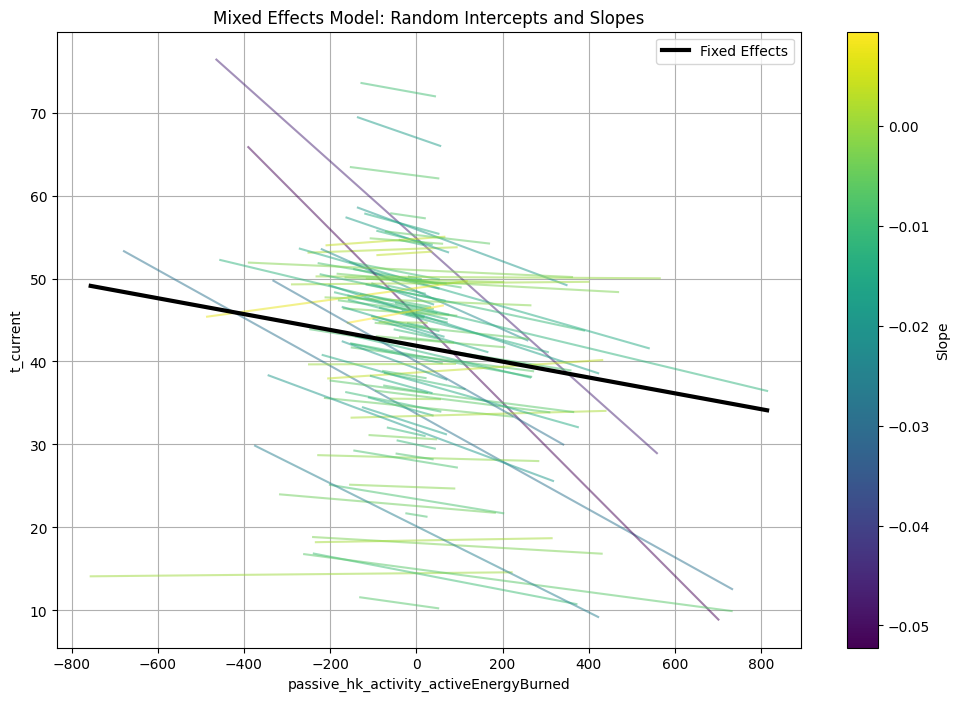

--------------------------------
AIC: 35308.2840
BIC: 35339.9563
--------------------------------
                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             t_current  
No. Observations:              4165                Method:                         REML       
No. Groups:                    98                  Scale:                          257.9082   
Min. group size:               10                  Log-Likelihood:                 -17649.1420
Max. group size:               61                  Converged:                      Yes        
Mean group size:               42.5                                                           
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------

In [8]:
fit_single_variable_mlm(train_data, 'passive_hk_activity_activeEnergyBurned', target='t_current', random_intercepts=True)

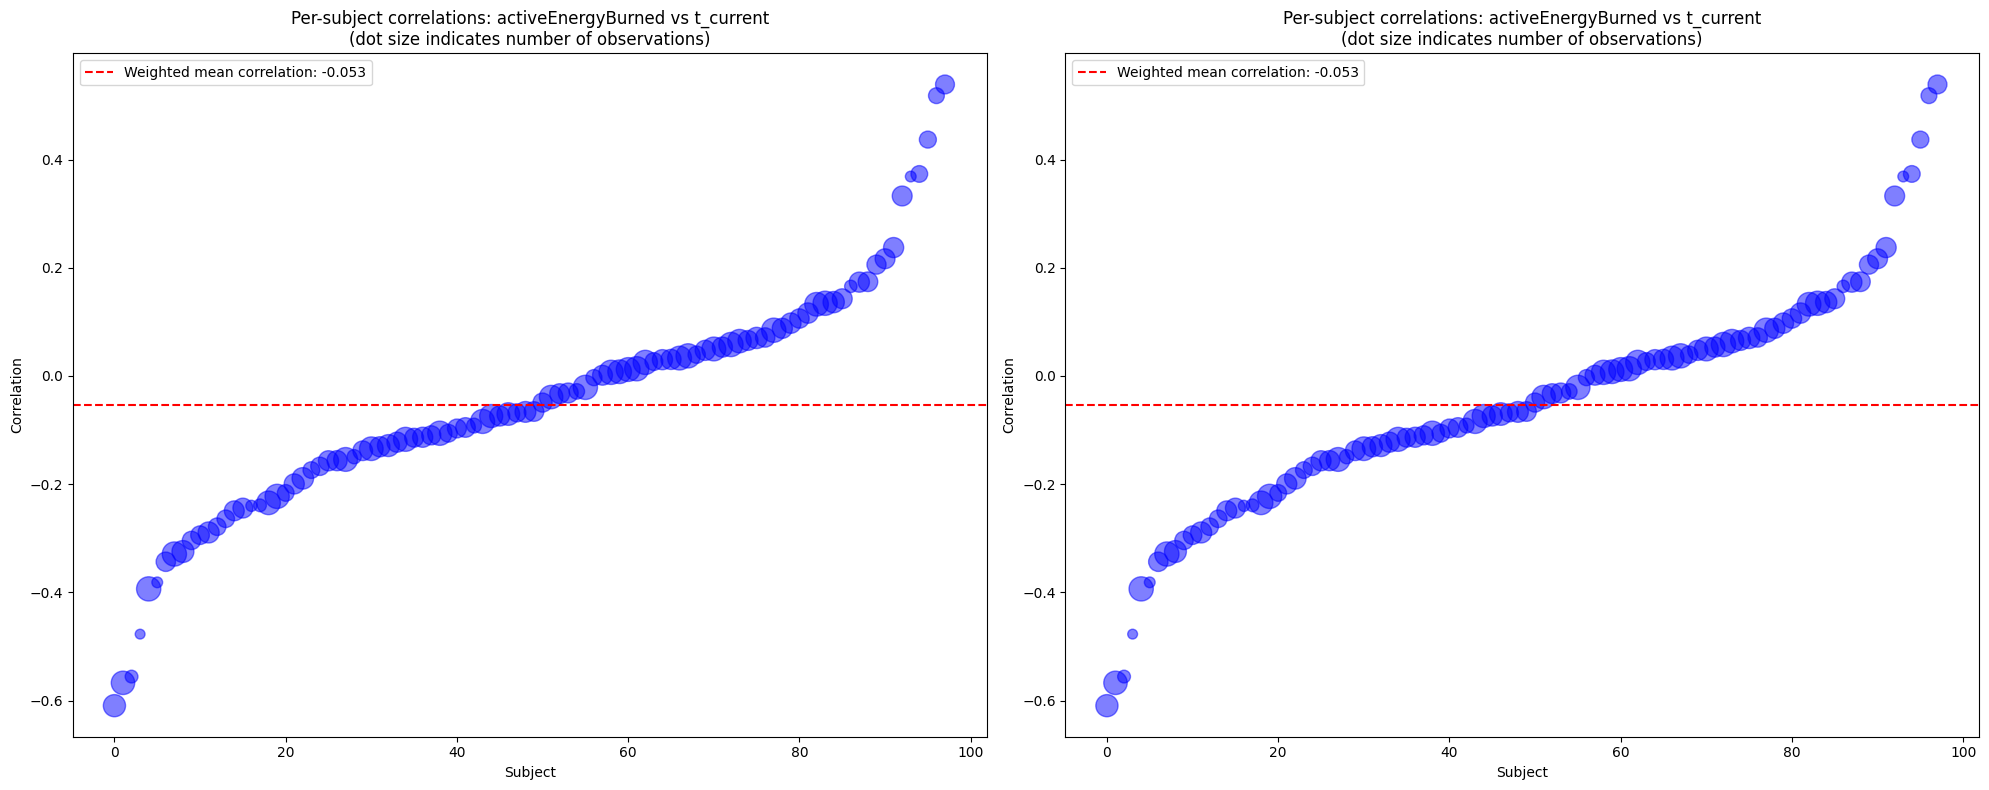

In [10]:
# Calculate per-subject correlations and observation counts

correlations_t = []
correlations_t_nn = []
n_obs_t = []
n_obs_t_nn = []
pids = train_data['PID'].unique()
pid_correlations = []

for pid in pids:
    subject_data = train_data[train_data['PID'] == pid]
    
    # Calculate correlation and obs count for t_current, only if there are valid values
    if not subject_data['passive_hk_activity_activeEnergyBurned'].isna().all() and not subject_data['t_current'].isna().all():
        valid_data = subject_data[['passive_hk_activity_activeEnergyBurned', 't_current']].dropna()
        # Only include if at least 10 observations
        if len(valid_data) >= 10:
            corr_t = valid_data['passive_hk_activity_activeEnergyBurned'].corr(valid_data['t_current'])
            if not np.isnan(corr_t):
                correlations_t.append(corr_t)
                n_obs_t.append(len(valid_data))
                pid_correlations.append({
                    'PID': pid,
                    'correlation': corr_t,
                    'n_obs': len(valid_data),
                    'target': 't_current'
                })
    
    # Calculate correlation and obs count for t_current, only if there are valid values
    if not subject_data['passive_hk_activity_activeEnergyBurned'].isna().all() and not subject_data['t_current'].isna().all():
        valid_data = subject_data[['passive_hk_activity_activeEnergyBurned', 't_current']].dropna()
        # Only include if at least 10 observations
        if len(valid_data) >= 10:
            corr_t_nn = valid_data['passive_hk_activity_activeEnergyBurned'].corr(valid_data['t_current'])
            if not np.isnan(corr_t_nn):
                correlations_t_nn.append(corr_t_nn)
                n_obs_t_nn.append(len(valid_data))
                pid_correlations.append({
                    'PID': pid,
                    'correlation': corr_t_nn,
                    'n_obs': len(valid_data),
                    'target': 't_current'
                })

# Convert to dataframe
pid_correlations_df = pd.DataFrame(pid_correlations)

# Get PIDs with 5 most negative and positive correlations for each target, with at least 25 observations
most_negative_t = pid_correlations_df[(pid_correlations_df['target'] == 't_current') & 
                                    (pid_correlations_df['n_obs'] >= 25)].nsmallest(5, 'correlation')['PID'].tolist()
most_positive_t = pid_correlations_df[(pid_correlations_df['target'] == 't_current') & 
                                    (pid_correlations_df['n_obs'] >= 25)].nlargest(5, 'correlation')['PID'].tolist()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Sort correlations and corresponding observation counts
sorted_indices_t = np.argsort(correlations_t)
correlations_t_sorted = np.array(correlations_t)[sorted_indices_t]
n_obs_t_sorted = np.array(n_obs_t)[sorted_indices_t]

# Calculate weighted mean for t_current
mean_corr_t = np.average(correlations_t, weights=n_obs_t)

# Plot correlations for t_current with size based on observations
ax1.scatter(range(len(correlations_t)), correlations_t_sorted, alpha=0.5, 
           s=[n*5 for n in n_obs_t_sorted], c='blue')
ax1.axhline(y=mean_corr_t, color='r', linestyle='--', 
            label=f'Weighted mean correlation: {mean_corr_t:.3f}')
ax1.set_xlabel('Subject')
ax1.set_ylabel('Correlation')
ax1.set_title('Per-subject correlations: activeEnergyBurned vs t_current\n(dot size indicates number of observations)')
ax1.legend()

# Sort correlations and corresponding observation counts for t_current
sorted_indices_t_nn = np.argsort(correlations_t_nn)
correlations_t_nn_sorted = np.array(correlations_t_nn)[sorted_indices_t_nn]
n_obs_t_nn_sorted = np.array(n_obs_t_nn)[sorted_indices_t_nn]

# Calculate weighted mean for t_current
mean_corr_t_nn = np.average(correlations_t_nn, weights=n_obs_t_nn)

# Plot correlations for t_current with size based on observations
ax2.scatter(range(len(correlations_t_nn)), correlations_t_nn_sorted, alpha=0.5,
           s=[n*5 for n in n_obs_t_nn_sorted], c='blue')
ax2.axhline(y=mean_corr_t_nn, color='r', linestyle='--',
            label=f'Weighted mean correlation: {mean_corr_t_nn:.3f}')
ax2.set_xlabel('Subject')
ax2.set_ylabel('Correlation')
ax2.set_title('Per-subject correlations: activeEnergyBurned vs t_current\n(dot size indicates number of observations)')
ax2.legend()

plt.tight_layout()
plt.show()


In [11]:
# Subset PIDs with most extreme correlations

predictor = 'passive_hk_activity_activeEnergyBurned'
target = 't_current'

train_subset = train_data[train_data['PID'].isin(most_positive_t)]
test_subset = test_data[test_data['PID'].isin(most_positive_t)]

fit_and_predict_mlm(train_subset, test_subset, predictor, target='t_current', random_intercepts=False)

# Calculate baseline error
# Calculate mean target value per PID in training data
pid_means = train_subset.groupby('PID')[target].mean()

# Make predictions using PID means
predictions = []
actuals = []

for pid in test_subset['PID'].unique():
    # Get test data for this PID
    pid_test_data = test_subset[test_subset['PID'] == pid]
    
    # Use training mean for this PID as prediction
    if pid in pid_means:
        pred_value = pid_means[pid]
        predictions.extend([pred_value] * len(pid_test_data))
        actuals.extend(pid_test_data[target].values)

predictions = np.array(predictions)
actuals = np.array(actuals)

# Calculate errors
errors = actuals - predictions
mae = np.nanmean(np.abs(errors))
rmse = np.sqrt(np.nanmean(errors**2))

print("\nBaseline Error Metrics (Using PID means):")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


NameError: name 'fit_and_predict_mlm' is not defined

# Baseline Model

This function calculates the mean `t_current` for each subject in the training data, uses these means to make predictions on the test data, and evaluates the model's performance using Mean Absolute Error (MAE) and Root Mean Square Error (RMSE). It also generates visualizations of the prediction errors and actual vs predicted values.

In [12]:
def baseline_model(train_data, test_data, target_col='t_current'):
    """
    Implements a baseline model for predicting target values.

    This function calculates the mean target value for each subject in the training data,
    uses these means to make predictions on the test data, and evaluates the model's
    performance using Mean Absolute Error (MAE) and Root Mean Square Error (RMSE).
    It also generates visualizations of the prediction errors and actual vs predicted values.

    Parameters:
    train_data (pd.DataFrame): Training data containing 'PID' and target column.
    test_data (pd.DataFrame): Test data containing 'PID' and target column.
    target_col (str): Name of the target column to predict. Defaults to 't_current'.

    Returns:
    tuple: A tuple containing:
        - mae (float): Mean Absolute Error of the predictions.
        - rmse (float): Root Mean Square Error of the predictions.
        - test_data_clean (pd.DataFrame): Test data with predictions and error calculations.

    The function also prints the MAE and RMSE, and displays two plots:
    1. A histogram of prediction errors.
    2. A scatter plot of actual vs predicted target values.
    """

    # Calculate within-subject mean for target in train data
    subject_means = train_data.groupby('PID')[target_col].mean()

    # Make predictions
    test_data['predicted_target'] = test_data['PID'].map(subject_means)

    # Remove rows with NaN values
    test_data_clean = test_data.dropna(subset=[target_col, 'predicted_target'])

    # Calculate differences
    test_data_clean = test_data_clean.copy()
    test_data_clean.loc[:, 'prediction_error'] = test_data_clean[target_col] - test_data_clean['predicted_target']

    # Calculate MAE and RMSE
    mae = mean_absolute_error(test_data_clean[target_col], test_data_clean['predicted_target'])
    rmse = np.sqrt(mean_squared_error(test_data_clean[target_col], test_data_clean['predicted_target']))

    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Square Error: {rmse:.4f}")

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot A: Distribution of Prediction Errors
    sns.histplot(test_data_clean['prediction_error'], kde=True, ax=ax1)
    ax1.set_xlabel('Prediction Error', fontsize=22)
    ax1.set_ylabel('Count', fontsize=22)
    ax1.axvline(x=0, color='r', linestyle='--')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=32, fontweight='bold', va='top', ha='right')

    # Plot B: Actual vs Predicted Values
    unique_pids = test_data_clean['PID'].unique()
    n_pids = len(unique_pids)
    colors = plt.cm.viridis(np.linspace(0, 1, n_pids))
    pid_color_map = dict(zip(unique_pids, colors))
    
    for pid in unique_pids:
        mask = test_data_clean['PID'] == pid
        ax2.scatter(test_data_clean.loc[mask, target_col], 
                   test_data_clean.loc[mask, 'predicted_target'],
                   color=pid_color_map[pid],
                   alpha=0.5)
    
    ax2.plot([test_data_clean[target_col].min(), test_data_clean[target_col].max()], 
             [test_data_clean[target_col].min(), test_data_clean[target_col].max()], 
             'r--', lw=2)
    ax2.set_xlabel('Actual IB Gap', fontsize=22)
    ax2.set_ylabel('Predicted IB Gap', fontsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=32, fontweight='bold', va='top', ha='right')

    plt.tight_layout()
    plt.show()

Mean Absolute Error: 11.5068
Root Mean Square Error: 15.1274


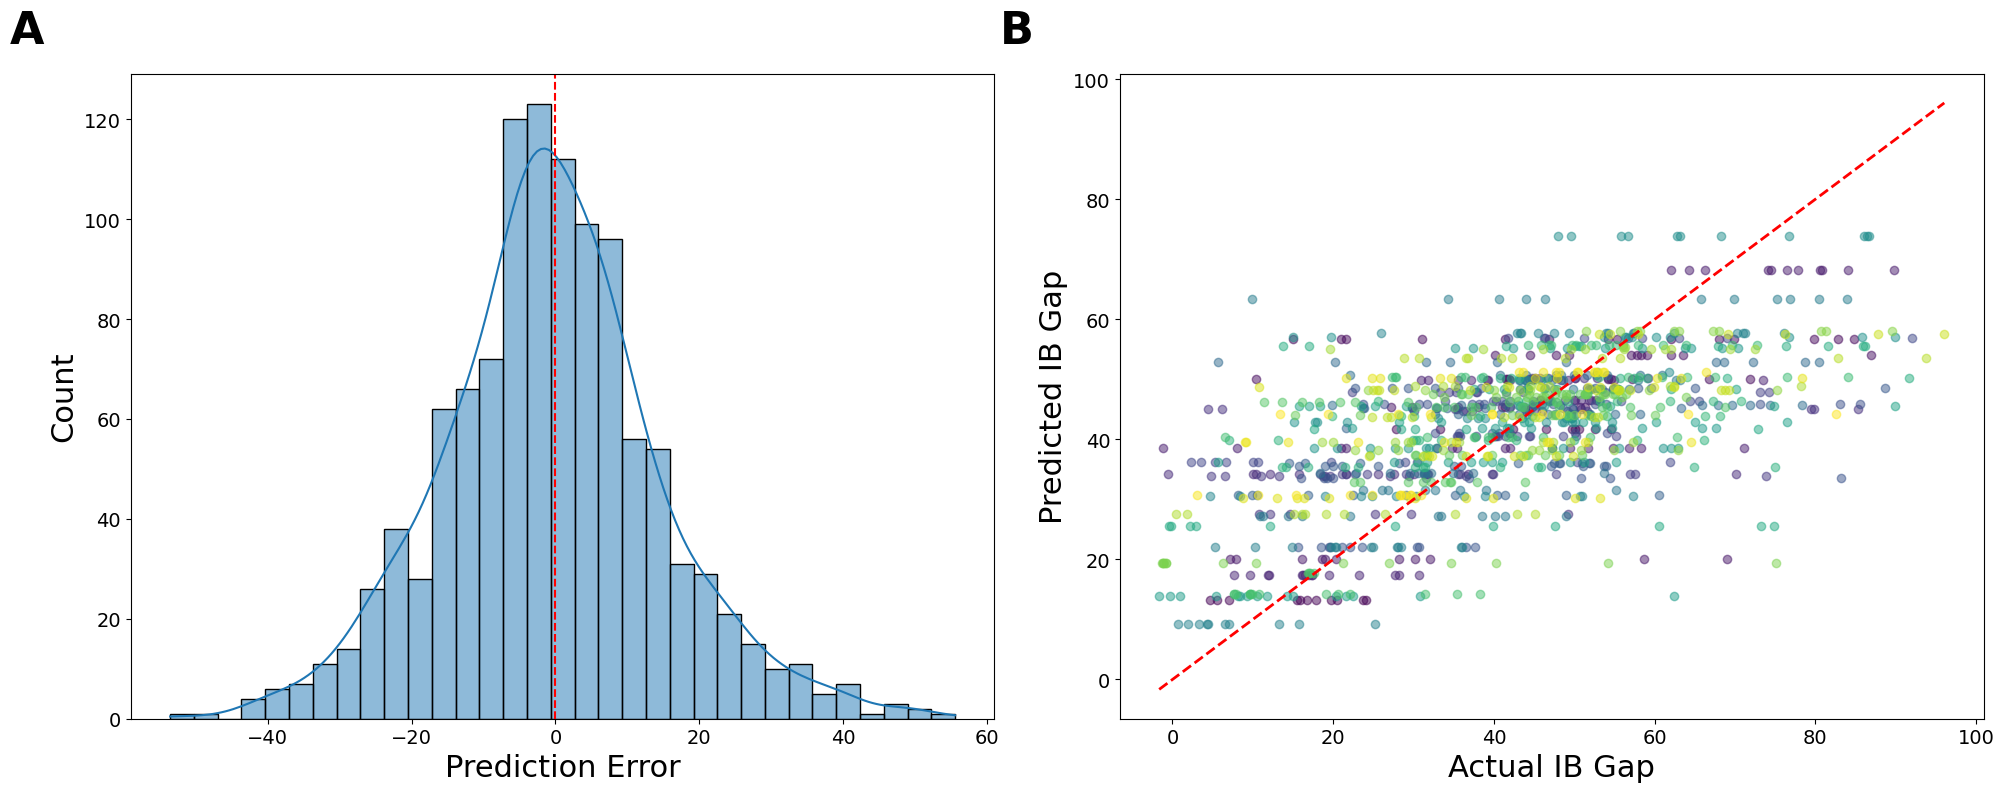

In [13]:
baseline_model(train_data, test_data, target_col='t_current')

# Hierarchical Models

## Functions

In [ ]:
def fit_and_predict_mlm(train_data, test_data, predictors, target='t_current', random_intercepts=True):
    """
    Fits a mixed linear model on training data and makes predictions on test data.
    Model has random slopes and optional random intercepts.
    
    Parameters
    ----------
    train_data : pandas.DataFrame
        Training dataset containing predictors, target, and grouping variable ('PID')
    test_data : pandas.DataFrame
        Test dataset containing same columns as train_data
    predictors : str or list
        Predictor variable name(s)
    target : str, default='t_current'
        Name of the target variable
    random_intercepts : bool, default=True
        Whether to include random intercepts in the model
    
    Returns
    -------
    model : statsmodels.regression.mixed_linear_model.MixedLMResults
        Fitted model object
    predictions : numpy.array
        Array of predictions for test data
    test_actual : pandas.Series
        Actual target values from test data
    """
    # Convert single predictor to list if needed
    if isinstance(predictors, str):
        predictors = [predictors]
        
    # Prepare training data
    train_data_clean = train_data[predictors + [target, 'PID']].dropna()
    
    # Normalize each feature column within each participant
    for predictor in predictors:
        train_data_clean[predictor] = train_data_clean.groupby('PID')[predictor].transform(lambda x: (x - x.mean()) / x.std())
    
    # Remove any NaN values that were introduced by normalization
    train_data_clean = train_data_clean.dropna()
    
    # Create formula string with all predictors
    predictor_formula = ' + '.join(predictors)
    
    # Fit model based on random_intercepts parameter
    if random_intercepts:
        md = smf.mixedlm(f"{target} ~ 1 + {predictor_formula}",
                        train_data_clean,
                        groups=train_data_clean["PID"],
                        re_formula=f"1 + {predictor_formula}")
    else:
        md = smf.mixedlm(f"{target} ~ 1 + {predictor_formula}",
                         train_data_clean,
                         groups=train_data_clean["PID"],
                         re_formula=f"0 + {predictor_formula}")
    
    try:
        model = md.fit(method='nm', maxiter=1000)
    except:
        # Try alternate optimizer if nm fails
        model = md.fit(method='bfgs', maxiter=1000)
    
    # Prepare test data
    test_data_clean = test_data[predictors + [target, 'PID', 'day']].dropna()
    
    # Normalize each predictor column in the test data
    for predictor in predictors:
        test_data_clean[predictor] = test_data_clean.groupby('PID')[predictor].transform(lambda x: (x - x.mean()) / x.std())
    
    # Remove any NaN values that were introduced by normalization
    test_data_clean = test_data_clean.dropna()
    
    # Predictions start at zero
    predictions = np.zeros(len(test_data_clean))
    
    # Get random effects for all subjects
    random_effects = model.random_effects
    
    # For each subject in test data
    for pid in test_data_clean['PID'].unique():
        mask = test_data_clean['PID'] == pid
        subject_data = test_data_clean[mask]
        
        if pid in random_effects:
            # Get subject's random effects if available
            re_slopes = {pred: random_effects[pid].get(pred, 0) for pred in predictors}
            # For random intercepts, we need to get the 'Group' effect
            re_intercept = random_effects[pid].get('Group', 0) if random_intercepts else 0
        else:
            # Default to 0 if subject not in random effects
            re_slopes = {pred: 0 for pred in predictors}
            re_intercept = 0
        
        # Calculate prediction using fixed effects + random effects
        if random_intercepts:
            # Include the fixed intercept when using random intercepts
            fixed_intercept = model.params.get('Intercept', 0)
            pred_values = fixed_intercept + re_intercept
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            predictions[mask] = pred_values
        else:
            pred_values = np.zeros(len(subject_data))
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            predictions[mask] = pred_values
            
    test_actual = test_data_clean[target]
    
    print(model.summary())
    
    return model, predictions, test_actual, test_data_clean

In [26]:
def calculate_metrics(model, predictions, test_actual, test_data_clean, train_data, results=None):
    """
    Calculate various performance metrics for a mixed effects model.
    
    Args:
        model: The fitted mixed effects model
        predictions: Array of model predictions
        test_actual: Array of actual test values
        test_data_clean: DataFrame containing cleaned test data
        train_data: DataFrame containing training data
        results: Optional DataFrame to append results to. If None, creates new DataFrame.
        
    Returns:
        DataFrame: DataFrame containing metrics for this model and any previous models if results was passed
    """
    ######################
    # CONTINUOUS METRICS #
    ######################
    mae = np.mean(np.abs(test_actual - predictions))
    rmse = np.sqrt(np.mean((test_actual - predictions)**2))
    
    # Calculate AIC and BIC for test data
    n = len(test_actual)  # number of observations
    k = len(model.params)  # number of parameters
    mse = np.mean((test_actual - predictions)**2)
    ll = -n/2 * (np.log(2*np.pi) + np.log(mse) + 1)  # log likelihood
    aic = 2*k - 2*ll  # AIC
    bic = k*np.log(n) - 2*ll  # BIC
    
    #######################
    # CATEGORICAL METRICS #
    #######################
    # Calculate median target value per subject from training data
    train_medians = train_data.groupby('PID')['t_current'].median()
    
    # Get subject-specific medians for test data subjects 
    test_subject_medians = pd.Series(index=test_data_clean['PID'],
                                   data=[train_medians[pid] if pid in train_medians.index else np.nan 
                                        for pid in test_data_clean['PID']])
    
    # Calculate binary classifications (above/below median)
    # Reset indices and convert to numpy arrays to avoid Series alignment issues
    actual_above_median = test_actual.reset_index(drop=True).to_numpy() > test_subject_medians.reset_index(drop=True).to_numpy()
    predicted_above_median = predictions > test_subject_medians.reset_index(drop=True).to_numpy()
    
    # Calculate accuracy of above/below median predictions
    median_accuracy = np.mean(actual_above_median == predicted_above_median)
    
    # Bootstrap 95% confidence interval for median accuracy
    n_bootstrap = 1000
    bootstrap_accuracies = []
    
    # Get indices for all samples
    indices = np.arange(len(actual_above_median))
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = actual_above_median[bootstrap_indices]
        bootstrap_predicted = predicted_above_median[bootstrap_indices]
        
        # Calculate accuracy for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        bootstrap_accuracies.append(bootstrap_acc)
    
    # Calculate 95% confidence interval
    ci_lower, ci_upper = np.percentile(bootstrap_accuracies, [2.5, 97.5])
    
    # Calculate tercile boundaries per subject from training data
    train_terciles = train_data.groupby('PID')['t_current'].quantile([0.333, 0.667]).unstack()
    
    # Get subject-specific tercile boundaries for test data subjects
    test_subject_upper_tercile = pd.Series(
        index=test_data_clean['PID'],
        data=[train_terciles.loc[pid, 0.667] if pid in train_terciles.index else np.nan 
              for pid in test_data_clean['PID']]
    )
    
    # Calculate high gap classifications (top tercile)
    # Reset indices and convert to numpy arrays to avoid Series alignment issues
    actual_high_gap = test_actual.reset_index(drop=True).to_numpy() > test_subject_upper_tercile.reset_index(drop=True).to_numpy()
    predicted_high_gap = predictions > test_subject_upper_tercile.reset_index(drop=True).to_numpy()
    
    # Calculate accuracy of high gap predictions
    high_gap_accuracy = np.mean(actual_high_gap == predicted_high_gap)
    
    # Calculate precision and recall for high gap predictions
    high_gap_precision = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(predicted_high_gap == True)
    high_gap_recall = np.sum((actual_high_gap == True) & (predicted_high_gap == True)) / np.sum(actual_high_gap == True)
    high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall)
    
    # Bootstrap 95% confidence interval for high gap metrics
    n_bootstrap = 1000
    bootstrap_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    # Get indices for all samples
    indices = np.arange(len(actual_high_gap))
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = actual_high_gap[bootstrap_indices]
        bootstrap_predicted = predicted_high_gap[bootstrap_indices]
        
        # Calculate metrics for this bootstrap sample
        bootstrap_metrics['accuracy'].append(np.mean(bootstrap_actual == bootstrap_predicted))
        
        # Calculate precision (handling division by zero)
        if np.sum(bootstrap_predicted == True) > 0:
            prec = np.sum((bootstrap_actual == True) & (bootstrap_predicted == True)) / np.sum(bootstrap_predicted == True)
        else:
            prec = 0
        bootstrap_metrics['precision'].append(prec)
        
        # Calculate recall (handling division by zero)
        if np.sum(bootstrap_actual == True) > 0:
            rec = np.sum((bootstrap_actual == True) & (bootstrap_predicted == True)) / np.sum(bootstrap_actual == True)
        else:
            rec = 0
        bootstrap_metrics['recall'].append(rec)
        
        # Calculate F1 (handling division by zero)
        if prec + rec > 0:
            f1 = 2 * (prec * rec) / (prec + rec)
        else:
            f1 = 0
        bootstrap_metrics['f1'].append(f1)
    
    # Calculate 95% confidence intervals for all metrics
    high_gap_cis = {
        metric: np.percentile(scores, [2.5, 97.5]) 
        for metric, scores in bootstrap_metrics.items()
    }
    
    # Calculate day-to-day changes accounting for gaps in data
    test_data_sorted = test_data_clean.sort_values(['PID', 'day'])

    # Initialize arrays to store valid changes
    actual_changes = []
    predicted_changes = []

    # Process each subject separately
    for pid in test_data_sorted['PID'].unique():
        subject_data = test_data_sorted[test_data_sorted['PID'] == pid].copy()
        subject_data = subject_data.reset_index(drop=True)  # Reset index for each subject
        
        # Get days that have both actual and predicted values
        valid_days = subject_data.day.values
        
        # For each valid day (except first), check if previous day exists
        for i in range(1, len(valid_days)):
            current_day = valid_days[i]
            prev_day = valid_days[i-1]
            
            # Only calculate change if days are consecutive
            if current_day - prev_day == 1:
                # Get the actual values directly using integer indices
                current_actual = test_actual.iloc[subject_data.index[i]]
                prev_actual = test_actual.iloc[subject_data.index[i-1]]
                
                current_pred = predictions[subject_data.index[i]]
                prev_pred = predictions[subject_data.index[i-1]]
                
                # Calculate changes
                actual_change = current_actual - prev_actual
                predicted_change = current_pred - prev_pred
                
                actual_changes.append(actual_change)
                predicted_changes.append(predicted_change)
    
    # Convert to numpy arrays
    actual_changes = np.array(actual_changes)
    predicted_changes = np.array(predicted_changes)
    
    # Calculate if changes have same sign
    actual_direction = np.sign(actual_changes)
    predicted_direction = np.sign(predicted_changes)
    
    # Calculate base direction accuracy
    direction_accuracy = np.mean(actual_direction == predicted_direction)
    
    # Bootstrap to get confidence interval
    n_bootstrap = 1000
    bootstrap_direction_accuracies = []
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        indices = np.random.randint(0, len(actual_direction), size=len(actual_direction))
        bootstrap_actual = actual_direction[indices]
        bootstrap_predicted = predicted_direction[indices]
        
        # Calculate accuracy for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        bootstrap_direction_accuracies.append(bootstrap_acc)
    
    # Calculate 95% confidence interval
    direction_ci_lower, direction_ci_upper = np.percentile(bootstrap_direction_accuracies, [2.5, 97.5])
    
    # Print metrics
    print(f"Model Performance Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Log Likelihood: {ll:.4f}")
    print(f"AIC: {aic:.4f}")
    print(f"BIC: {bic:.4f}")
    print(f"\nCategorical Metrics:")
    print(f"Above/Below Median, Accuracy: {median_accuracy*100:.2f}%")
    print(f"Above/Below Median, 95% CI: [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
    print(f"\nHigh Gap Classification Metrics (Top Tercile):")
    print(f"Accuracy: {high_gap_accuracy*100:.2f}% [95% CI: {high_gap_cis['accuracy'][0]*100:.2f}%, {high_gap_cis['accuracy'][1]*100:.2f}%]")
    print(f"Precision: {high_gap_precision*100:.2f}% [95% CI: {high_gap_cis['precision'][0]*100:.2f}%, {high_gap_cis['precision'][1]*100:.2f}%]")
    print(f"Recall: {high_gap_recall*100:.2f}% [95% CI: {high_gap_cis['recall'][0]*100:.2f}%, {high_gap_cis['recall'][1]*100:.2f}%]")
    print(f"F1 Score: {high_gap_f1*100:.2f}% [95% CI: {high_gap_cis['f1'][0]*100:.2f}%, {high_gap_cis['f1'][1]*100:.2f}%]")
    print(f"\nDay-to-Day Change Direction Accuracy: {direction_accuracy*100:.2f}%")
    print(f"Day-to-Day Change Direction, 95% CI: [{direction_ci_lower*100:.2f}%, {direction_ci_upper*100:.2f}%]")
    
    # Calculate per-PID RMSE
    pid_rmse = {}
    for pid in test_data_clean['PID'].unique():
        pid_mask = test_data_clean['PID'] == pid
        pid_actual = test_actual[pid_mask]
        pid_pred = predictions[pid_mask]
        pid_rmse[pid] = np.sqrt(mean_squared_error(pid_actual, pid_pred))
    
    # Rank PIDs by RMSE
    pid_rmse_ranking = {pid: rank for rank, (pid, _) in 
                       enumerate(sorted(pid_rmse.items(), key=lambda x: x[1]))}
    
    # Create new row of results
    new_results = pd.DataFrame({
        'n_predictors': [len(model.model.exog_names) - 1], # Subtract 1 for intercept
        'predictors': [model.model.exog_names[1:]], # Skip intercept term
        'mae': [mae],
        'rmse': [rmse],
        'pid_rmse_ranking': [pid_rmse_ranking],
        'log_likelihood': [ll],
        'aic': [aic], 
        'bic': [bic],
        'median_accuracy': [median_accuracy],
        'median_ci_lower': [ci_lower],
        'median_ci_upper': [ci_upper],
        'high_gap_accuracy': [high_gap_accuracy],
        'high_gap_precision': [high_gap_precision],
        'high_gap_recall': [high_gap_recall],
        'high_gap_f1': [high_gap_f1],
        'high_gap_ci_accuracy_lower': [high_gap_cis['accuracy'][0]],
        'high_gap_ci_accuracy_upper': [high_gap_cis['accuracy'][1]],
        'high_gap_ci_precision_lower': [high_gap_cis['precision'][0]],
        'high_gap_ci_precision_upper': [high_gap_cis['precision'][1]], 
        'high_gap_ci_recall_lower': [high_gap_cis['recall'][0]],
        'high_gap_ci_recall_upper': [high_gap_cis['recall'][1]],
        'high_gap_ci_f1_lower': [high_gap_cis['f1'][0]],
        'high_gap_ci_f1_upper': [high_gap_cis['f1'][1]],
        'direction_accuracy': [direction_accuracy],
        'direction_ci_lower': [direction_ci_lower],
        'direction_ci_upper': [direction_ci_upper]
    })
    
    # If results DataFrame exists, append new results
    if results is not None:
        results = pd.concat([results, new_results], ignore_index=True)
    else:
        results = new_results
        
    return results

In [ ]:
def plot_model_diagnostics(test_actual, predictions, test_data_clean):
    """
    Create diagnostic plots for model evaluation.
    
    Parameters
    ----------
    test_actual : array-like
        The actual target values from the test set
    predictions : array-like 
        The model's predictions for the test set
    test_data_clean : pd.DataFrame
        The cleaned test dataset containing PID column for coloring points
        
    Returns
    -------
    None
        Displays two plots:
        1. Distribution of prediction errors
        2. Actual vs predicted values scatter plot colored by participant
    """
    # Create visualization plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    
    # Plot 1: Error distribution
    errors = test_actual - predictions
    sns.histplot(data=errors, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.set_title('Distribution of Prediction Errors')
    ax1.set_xlabel('Error (Actual - Predicted)')
    ax1.set_ylabel('Count')
    
    # Plot 2: Actual vs Predicted
    sns.scatterplot(x=test_actual, y=predictions, ax=ax2, alpha=0.5, 
                    hue=test_data_clean['PID'], palette='viridis', legend=False)
    ax2.plot([test_actual.min(), test_actual.max()],
                [test_actual.min(), test_actual.max()],
                'r--')
    ax2.set_title('Actual vs Predicted Values')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()

## MLM of Training Data Predictors

In [14]:
# Function to fit single predictor MLM for all specified features

def single_predictor_mlm_iterator(df, model_columns, target_col='t_current', random_intercepts=False):
    """
    Fits mixed linear models for each predictor variable to predict target variable.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the normalized feature data and target variable
    model_columns : list
        List of feature names to fit models for
    target_col : str
        Name of target column to predict (default: 't_current')
    random_intercepts : bool
        Whether to include random intercepts in the model (default: False)
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing model results for each feature, sorted by absolute t-value.
        Includes coefficients, t-values, p-values, and group statistics.
    """
    # Initialize an empty list to store results
    results = []

    # Loop through all variables with progress bar
    for col in tqdm(model_columns, desc="Fitting models"):
        try:
            # Prepare the data
            model_data = df[[col, target_col, 'PID']].dropna()
            
            # Normalize the feature column within each participant
            model_data[col] = model_data.groupby('PID')[col].transform(lambda x: (x - x.mean()) / x.std())
            
            # Remove any NaN values that were introduced by normalization
            model_data = model_data.dropna()
            
            # Filter out participants with less than 10 data points
            group_sizes = model_data.groupby('PID').size()
            valid_pids = group_sizes[group_sizes >= 10].index
            model_data = model_data[model_data['PID'].isin(valid_pids)]
            
            # Filter out columns with less than 10 subjects
            no_subs = len(np.unique(model_data['PID']))
            
            # Only proceed if there's enough data
            if len(model_data) > 0 and no_subs >= 10:
                if random_intercepts:
                    md = smf.mixedlm(f"{target_col} ~ 1 + {col}",
                        model_data,
                        groups=model_data["PID"],
                        re_formula=f"1 + {col}")
                else:
                    md = smf.mixedlm(f"{target_col} ~ 0 + {col}",
                        model_data,
                        groups=model_data["PID"],
                        re_formula=f"0 + {col}")

                converged = True
                try:
                    fit = md.fit(method='nm',
                                maxiter=1000,
                                start_params=None,
                                full_output=True)
                except:
                    print("Model failed to converge with nm")
                    try:
                        # Try alternate optimizer
                        fit = md.fit(method='bfgs',
                                    maxiter=1000,
                                    full_output=True)
                    except:
                        print(f"Model failed to converge with both optimizers for {col}")
                        converged = False
                
                # Extract relevant information
                coef = fit.params[col]
                coef_se = fit.bse[col]
                t_value = fit.tvalues[col]
                p_value = fit.pvalues[col]
                
                # Get group information
                groups = model_data.groupby('PID')
                n_groups = len(groups)
                min_group_size = groups.size().min()
                max_group_size = groups.size().max()
                mean_group_size = groups.size().mean()
                median_group_size = groups.size().median()
                
                # Append results to the list
                results.append({
                    'feature': col,
                    'coefficient': coef,
                    'SE': coef_se,
                    'z': t_value,
                    'abs_z': abs(t_value),
                    'p_value': p_value,
                    'n_groups': n_groups,
                    'min_group_size': min_group_size,
                    'max_group_size': max_group_size,
                    'mean_group_size': mean_group_size,
                    'median_group_size': median_group_size,
                    'converged': converged
                })
        except Exception as e:
            print(f"Error fitting model for {col}: {str(e)}")

    # Create a dataframe from the results
    mlm_gap_results_df = pd.DataFrame(results)

    # Sort the dataframe by absolute t-value in descending order
    mlm_gap_results_df = mlm_gap_results_df.sort_values('abs_z', ascending=False).reset_index(drop=True)
    
    return mlm_gap_results_df

In [15]:
# Get all features that were significant in the MLM above z = 2
model_columns = mlm_gap_df[mlm_gap_df['abs_t_value'] > 2]['feature'].tolist()

# Fit the model
mlm_gap_results_train = single_predictor_mlm_iterator(train_data, model_columns, target_col='t_current', random_intercepts=True)

Fitting models:  40%|███▉      | 27/68 [01:25<01:51,  2.72s/it]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Fitting models:  65%|██████▍   | 44/68 [02:35<01:08,  2.84s/it]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Fitting models:  68%|██████▊   | 46/68 [02:44<01:19,  3.61s/it]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sta

## Top 1 Predictor

                              Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              t_current  
No. Observations:                4796                 Method:                          REML       
No. Groups:                      104                  Scale:                           248.5385   
Min. group size:                 13                   Log-Likelihood:                  -20243.5015
Max. group size:                 61                   Converged:                       Yes        
Mean group size:                 46.1                                                             
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

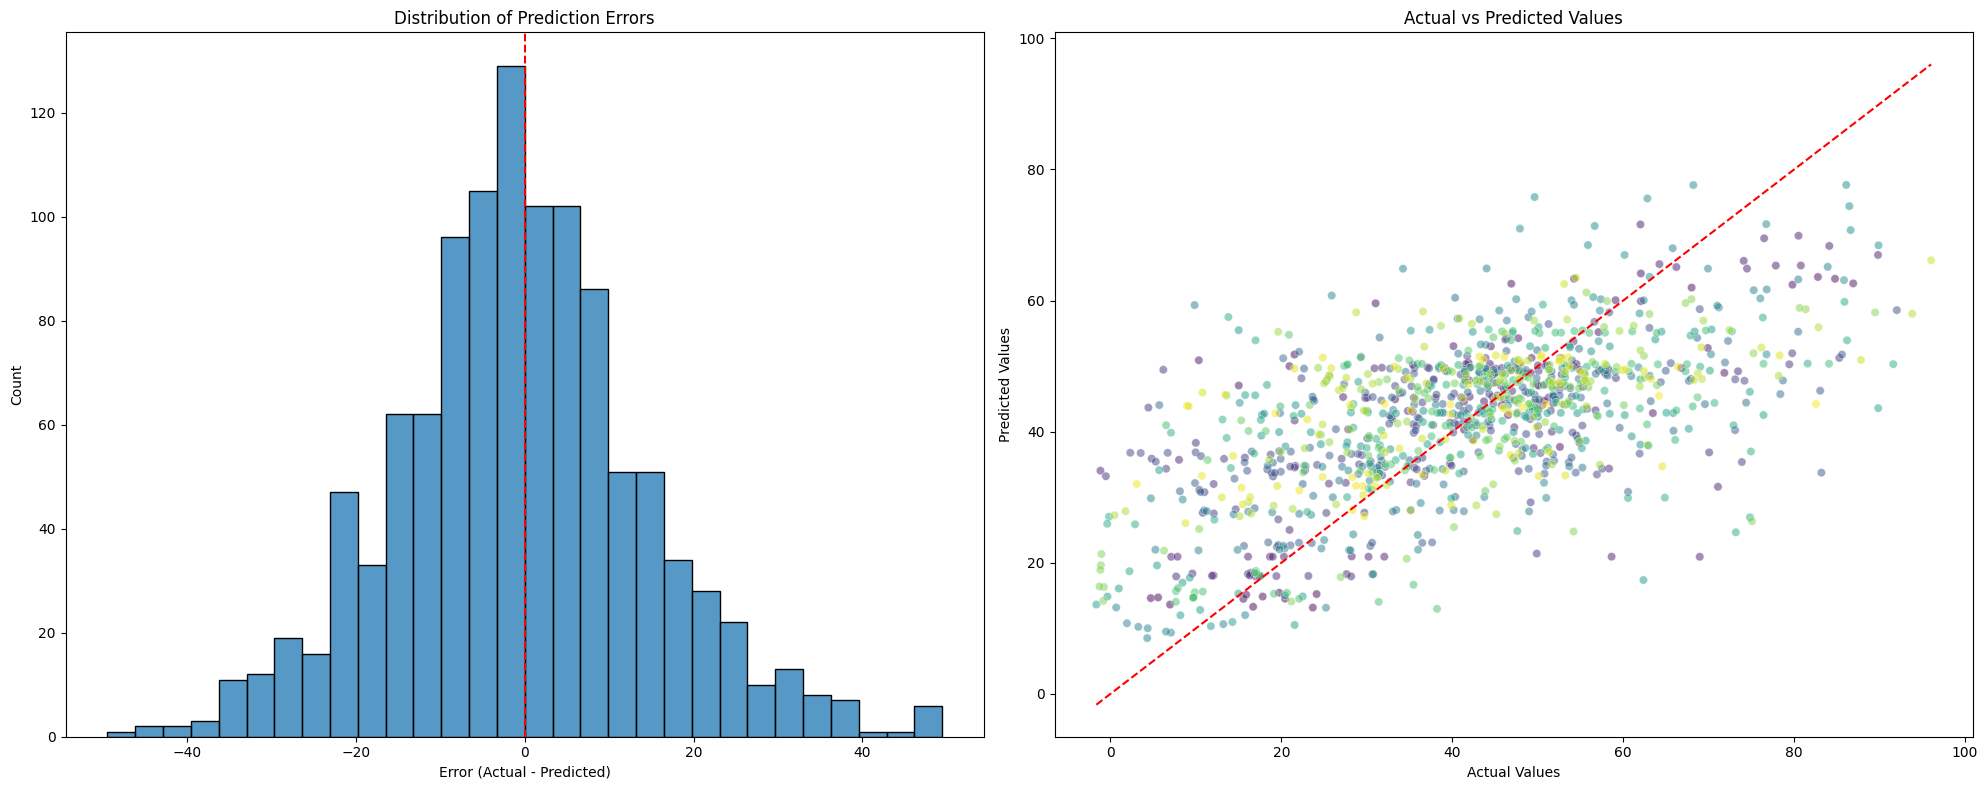

In [27]:
# Get the first feature from the MLM results
predictor = mlm_gap_results_train.iloc[0]['feature']

model, predictions, test_actual, test_data_clean = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictor, 
                                                                       target='t_current', 
                                                                       random_intercepts=True)

results_df = calculate_metrics(model, predictions, test_actual, test_data_clean, train_data)

plot_model_diagnostics(test_actual, predictions, test_data_clean)

In [28]:
results_df

,n_predictors,predictors,mae,rmse,pid_rmse_ranking,log_likelihood,aic,bic,median_accuracy,median_ci_lower,...,high_gap_ci_accuracy_upper,high_gap_ci_precision_lower,high_gap_ci_precision_upper,high_gap_ci_recall_lower,high_gap_ci_recall_upper,high_gap_ci_f1_lower,high_gap_ci_f1_upper,direction_accuracy,direction_ci_lower,direction_ci_upper
0,1,[passive_hk_activity_distanceWalkingRunning],11.457976,14.900431,"{'a9de00be-460d-4b74-bed3-bf013fe2052a': 0, '1...",-4623.008782,9256.017564,9281.131904,0.565954,0.534759,...,0.714817,0.352941,0.678607,0.029584,0.075764,0.054717,0.13577,0.524573,0.49359,0.556624


## Top 2 Predictors

In [31]:
def fit_and_predict_mlm_multiple(train_data, test_data, n_predictors, top_features, target='t_current', random_intercepts=True):
    """
    Fit MLM models with multiple predictors and evaluate performance.
    
    Parameters:
    -----------
    train_data, test_data : pd.DataFrame
        Training and test datasets
    n_predictors : int
        Number of predictors to use in each model (2 or 3)
    top_features : list
        Ordered list of features to consider for combinations
    target : str
        Target column name
    random_intercepts : bool
        Whether to include random intercepts in the model
    """
    # Generate all possible combinations
    feature_combinations = list(combinations(top_features, n_predictors))
    
    # Initialize results storage
    results = []
    
    print(f"Fitting models with {n_predictors} predictors...")
    for features in tqdm(feature_combinations):
            # Prepare training data
            train_data_clean = train_data[list(features) + [target, 'PID']].dropna()
            
            # Normalize each feature column within each participant
            for feature in features:
                train_data_clean[feature] = train_data_clean.groupby('PID')[feature].transform(lambda x: (x - x.mean()) / x.std())
            
            # Remove any NaN values that were introduced by normalization
            train_data_clean = train_data_clean.dropna()
            
            # Fit model based on random_intercepts parameter
            # Build formula string with all predictors
            predictor_formula = " + ".join(features)
            
            if random_intercepts:
                md = smf.mixedlm(f"{target} ~ 1 + {predictor_formula}",
                                train_data_clean,
                                groups=train_data_clean["PID"],
                                re_formula=f"1 + {predictor_formula}")
            else:
                md = smf.mixedlm(f"{target} ~ 1 + {predictor_formula}",
                                train_data_clean,
                                groups=train_data_clean["PID"],
                                re_formula=f"0 + {predictor_formula}")
            
            try:
                model = md.fit(method='nm', maxiter=1000)
            except:
                # Try alternate optimizer if nm fails
                model = md.fit(method='bfgs', maxiter=1000)
            
            # Prepare test data
            test_data_clean = test_data[list(features) + [target, 'PID']].dropna()
            
            # Normalize each feature column in the test data
            for feature in features:
                test_data_clean[feature] = test_data_clean.groupby('PID')[feature].transform(lambda x: (x - x.mean()) / x.std())
            
            # Remove any NaN values that were introduced by normalization
            test_data_clean = test_data_clean.dropna()
            
            # Predictions start at zero
            predictions = np.zeros(len(test_data_clean))
            
            # Get random effects for all subjects
            random_effects = model.random_effects
            
            # For each subject in test data
            for pid in test_data_clean['PID'].unique():
                mask = test_data_clean['PID'] == pid
                subject_data = test_data_clean[mask]
                
                if pid in random_effects:
                    # Get subject's random effects if available
                    re_slopes = {feat: random_effects[pid].get(feat, 0) for feat in features}
                    # For random intercepts, we need to get the 'Group' effect
                    re_intercept = random_effects[pid].get('Group', 0) if random_intercepts else 0
                else:
                    # Default to 0 if subject not in random effects
                    re_slopes = {feat: 0 for feat in features}
                    re_intercept = 0
                
                # Calculate prediction using fixed effects + random effects
                if random_intercepts:
                    # Start with intercepts
                    fixed_intercept = model.params.get('Intercept', 0)
                    pred = fixed_intercept + re_intercept
                    
                    # Add contribution from each predictor
                    for feature in features:
                        pred += (model.params[feature] + re_slopes[feature]) * subject_data[feature]
                    
                    predictions[mask] = pred
                else:
                    # Without random intercepts, start from 0
                    pred = np.zeros(len(subject_data))
                    
                    # Add contribution from each predictor
                    for feature in features:
                        pred += (model.params[feature] + re_slopes[feature]) * subject_data[feature]
                    
                    predictions[mask] = pred
            
            # Calculate metrics
            test_actual = test_data_clean[target]
            mae = np.mean(np.abs(test_actual - predictions))
            rmse = np.sqrt(np.mean((test_actual - predictions)**2))
            
            # Calculate ll, AIC and BIC for test data
            n = len(test_actual)  # number of observations
            k = len(model.params)  # number of parameters
            mse = np.mean((test_actual - predictions)**2)
            ll = -n/2 * (np.log(2*np.pi) + np.log(mse) + 1)  # log likelihood
            aic = 2*k - 2*ll  # AIC
            bic = k*np.log(n) - 2*ll  # BIC
            
            # Store results
            result = {
                'mae': mae,
                'rmse': rmse,
                'log_likelihood': ll,
                'n_observations': n,
                'aic': aic,
                'bic': bic
            }
            
            # Add features to result
            for i, feature in enumerate(features, 1):
                result[f'feature_{i}'] = feature
                
            results.append(result)
    
    # Convert to DataFrame and sort by RMSE
    results_df = pd.DataFrame(results).sort_values('rmse')
    
    return results_df

In [29]:
def calculate_combinations(n_items, r):
    """
    Calculate number of possible combinations of n items taken r at a time.
    
    Args:
        n_items (int): Total number of items to choose from
        r (int): Number of items being chosen
        
    Returns:
        int: Number of possible combinations
    """
    from math import factorial
    
    return factorial(n_items) // (factorial(r) * factorial(n_items - r))

# Example usage:
n_features = 11
n_predictors = 3
n_combinations = calculate_combinations(n_features, n_predictors)
print(f"Number of possible combinations: {n_combinations}")


Number of possible combinations: 165


In [32]:
# Get top features from MLM results
top_features = mlm_gap_results_train.nlargest(22, 'abs_z')['feature'].tolist()

# Get results for 2 predictors
results_2pred = fit_and_predict_mlm_multiple(
    train_data=train_data,
    test_data=test_data,
    n_predictors=2,
    top_features=top_features,
    target='t_current',
    random_intercepts=True
)

Fitting models with 2 predictors...


 59%|█████▉    | 136/231 [17:08<12:10,  7.69s/it]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
100%|██████████| 231/231 [28:38<00:00,  7.44s/it]


                                               Mixed Linear Model Regression Results
Model:                                     MixedLM                          Dependent Variable:                          t_current  
No. Observations:                          4216                             Method:                                      REML       
No. Groups:                                103                              Scale:                                       247.6753   
Min. group size:                           9                                Log-Likelihood:                              -17789.4860
Max. group size:                           61                               Converged:                                   Yes        
Mean group size:                           40.9                                                                                     
---------------------------------------------------------------------------------------------------------------------

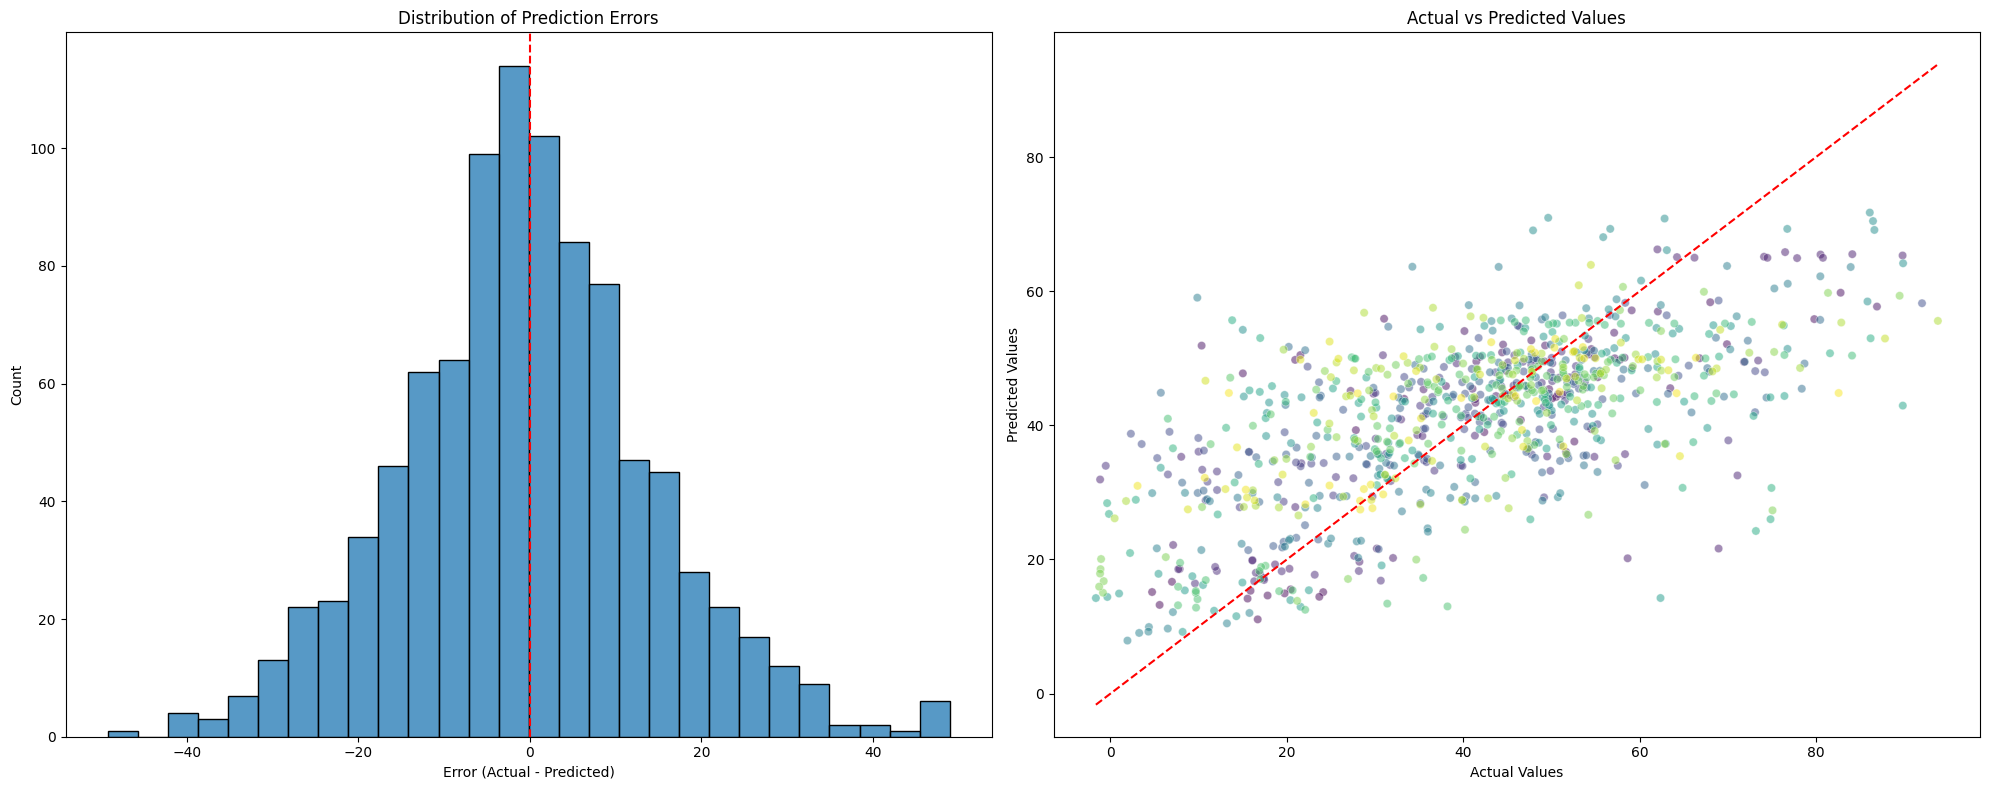

In [35]:
# Get the best model features
best_model = results_2pred.iloc[0]
feature_1 = best_model['feature_1']
feature_2 = best_model['feature_2']

model, predictions, test_actual, test_data_clean = fit_and_predict_mlm(
    train_data, 
    test_data, 
    predictors=[feature_1, feature_2],
    target='t_current', 
    random_intercepts=True
    )

results_df = calculate_metrics(model, predictions, test_actual, test_data_clean, train_data)

plot_model_diagnostics(test_actual, predictions, test_data_clean)

In [36]:
results_df

,n_predictors,predictors,mae,rmse,pid_rmse_ranking,log_likelihood,aic,bic,median_accuracy,median_ci_lower,...,high_gap_ci_accuracy_upper,high_gap_ci_precision_lower,high_gap_ci_precision_upper,high_gap_ci_recall_lower,high_gap_ci_recall_upper,high_gap_ci_f1_lower,high_gap_ci_f1_upper,direction_accuracy,direction_ci_lower,direction_ci_upper
0,2,"[passive_hk_activity_distanceWalkingRunning, p...",11.200675,14.63368,"{'a9de00be-460d-4b74-bed3-bf013fe2052a': 0, 'f...",-3880.742,7779.484,7823.154183,0.553911,0.521115,...,0.731501,0.434783,0.800192,0.035702,0.092361,0.065216,0.16353,0.609244,0.575595,0.644293


## Top 3 Predictors

In [33]:
# Get top features from MLM results
top_features = mlm_gap_results_train.nlargest(12, 'abs_z')['feature'].tolist()

# Get results for 2 predictors
results_3pred = fit_and_predict_mlm_multiple(
    train_data=train_data,
    test_data=test_data,
    n_predictors=3,
    top_features=top_features,
    target='t_current',
    random_intercepts=True
)

Fitting models with 3 predictors...


  0%|          | 0/220 [00:00<?, ?it/s]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 46.580880
  war

                                                        Mixed Linear Model Regression Results
Model:                                            MixedLM                               Dependent Variable:                               t_current  
No. Observations:                                 4062                                  Method:                                           REML       
No. Groups:                                       103                                   Scale:                                            245.5025   
Min. group size:                                  9                                     Log-Likelihood:                                   -17141.4157
Max. group size:                                  61                                    Converged:                                        Yes        
Mean group size:                                  39.4                                                                                               
------

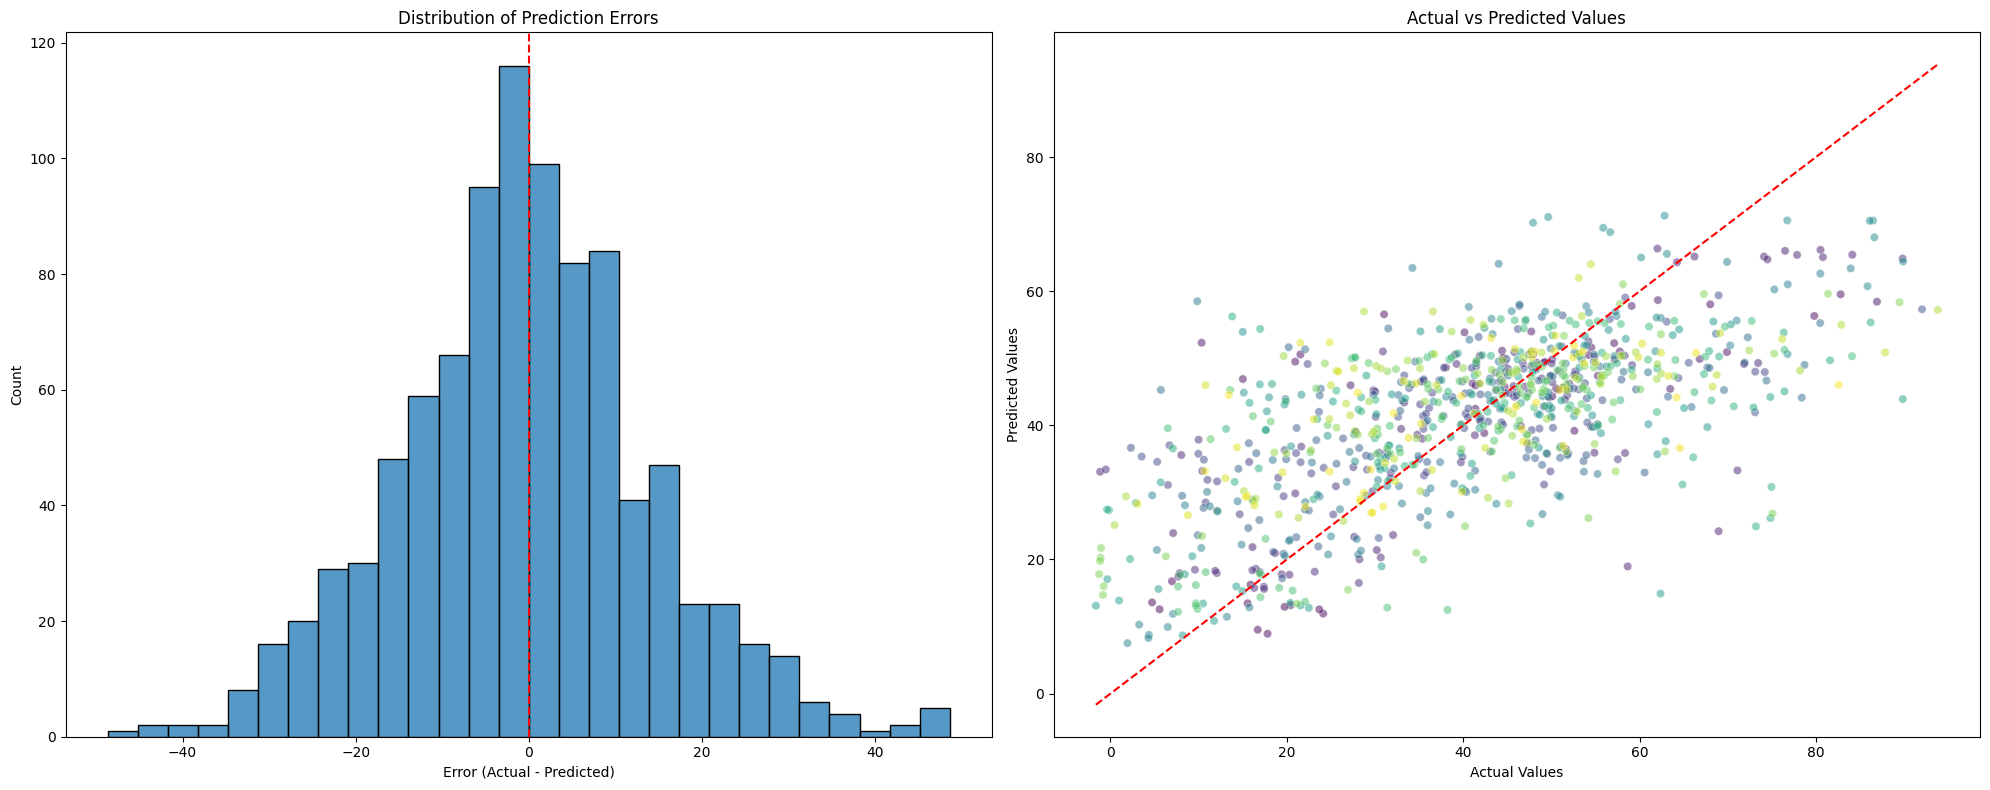

In [37]:
# Get the best model features
best_model = results_3pred.iloc[0]
feature_1 = best_model['feature_1']
feature_2 = best_model['feature_2']
feature_3 = best_model['feature_3']

# Fit and predict
model, predictions, test_actual, test_data_clean = fit_and_predict_mlm(
    train_data, 
    test_data, 
    predictors=[feature_1, feature_2, feature_3],
    target='t_current', 
    random_intercepts=True
    )

# Calculate metrics
results_df = calculate_metrics(model, predictions, test_actual, test_data_clean, train_data)

# Plot diagnostics
plot_model_diagnostics(test_actual, predictions, test_data_clean)

In [38]:
results_df

,n_predictors,predictors,mae,rmse,pid_rmse_ranking,log_likelihood,aic,bic,median_accuracy,median_ci_lower,...,high_gap_ci_accuracy_upper,high_gap_ci_precision_lower,high_gap_ci_precision_upper,high_gap_ci_recall_lower,high_gap_ci_recall_upper,high_gap_ci_f1_lower,high_gap_ci_f1_upper,direction_accuracy,direction_ci_lower,direction_ci_upper
0,3,"[passive_hk_activity_distanceWalkingRunning, p...",11.158581,14.543349,"{'a9de00be-460d-4b74-bed3-bf013fe2052a': 0, 'f...",-3854.404034,7736.808068,7804.665272,0.553666,0.522848,...,0.729012,0.4,0.717949,0.039568,0.098902,0.073084,0.172315,0.607042,0.571831,0.64088


In [92]:
# Calculate tercile thresholds per PID from training data
tercile_thresholds = train_data.groupby('PID')['t_current'].quantile(2/3).to_dict()

# Sort test data by PID and day to identify transitions
test_data_sorted = test_data.sort_values(['PID', 'day'])

# Create binary column for high gap states based on PID-specific thresholds
test_data_sorted['high_gap'] = test_data_sorted.apply(
    lambda row: row['t_current'] >= tercile_thresholds[row['PID']], 
    axis=1
)

# Create column for previous day's state
test_data_sorted['prev_high_gap'] = test_data_sorted.groupby('PID')['high_gap'].shift(1)

# Find transitions from low to high
transitions = test_data_sorted[
    (test_data_sorted['high_gap'] == True) & 
    (test_data_sorted['prev_high_gap'] == False)
]

# Count number of transition days
n_transitions = len(transitions)

print(f"Number of transitions into high gap state in test data: {n_transitions}")

# Show distribution of transitions by PID
pid_transitions = transitions.groupby('PID').size()
print("\nDistribution of transitions by participant:")
print(pid_transitions.describe())

# Print individual PID thresholds and their transition counts
print("\nPer-participant details:")
for pid in sorted(tercile_thresholds.keys()):
    n_trans = pid_transitions.get(pid, 0)
    print(f"PID {pid}: threshold = {tercile_thresholds[pid]:.2f}, transitions = {n_trans}")

# Count PIDs with 0 transitions
pids_with_no_transitions = len(set(test_data_sorted['PID']) - set(pid_transitions.index))
print(f"\nNumber of participants with 0 transitions: {pids_with_no_transitions}")

# Calculate total number of valid days (excluding first day per participant)
# Only count days where we have a target value
valid_days = test_data_sorted[~test_data_sorted['t_current'].isna()]
total_valid_days = len(valid_days) - len(valid_days['PID'].unique())  # Subtract first day per participant

# Calculate percentage
transition_percentage = (n_transitions / total_valid_days) * 100

print(f"\nExcluding first day per participant:")
print(f"Transition days: {n_transitions}")
print(f"Total valid days: {total_valid_days}")
print(f"Percentage of days with transitions: {transition_percentage:.1f}%")

Number of transitions into high gap state in test data: 209

Distribution of transitions by participant:
count    95.000000
mean      2.200000
std       0.882453
min       1.000000
25%       1.500000
50%       2.000000
75%       3.000000
max       4.000000
dtype: float64

Per-participant details:
PID 0151d9f1-1644-4437-805e-02f5e244a690: threshold = 16.58, transitions = 1
PID 02f48bee-6e86-437c-9394-10ae57dadd14: threshold = 52.04, transitions = 2
PID 0501ba67-3406-4779-aff1-878a0e9f7885: threshold = 69.30, transitions = 3
PID 06af7782-cd70-4938-8e67-b6d98b34b665: threshold = 54.65, transitions = 2
PID 075f7c4e-edea-4d64-8844-f046a1beb770: threshold = 62.36, transitions = 1
PID 077803ce-0421-40c5-846d-40f0a9ac6a83: threshold = 48.67, transitions = 2
PID 081555cf-aa19-4e1d-8b5a-223112ed0a35: threshold = 21.40, transitions = 3
PID 08e76051-ee6e-4872-896f-4ed3857afc0f: threshold = 76.52, transitions = 4
PID 0a06ff99-9b73-4f6a-8b36-cdf27b4c22fd: threshold = 46.28, transitions = 3
PID 0e14e

## Top 4 Predictors

In [34]:
# Get top features from MLM results
top_features = mlm_gap_results_train.nlargest(10, 'abs_z')['feature'].tolist()

# Get results for 4 predictors
results_4pred = fit_and_predict_mlm_multiple(
    train_data=train_data,
    test_data=test_data,
    n_predictors=4,
    top_features=top_features,
    target='t_current',
    random_intercepts=True
)

Fitting models with 4 predictors...


  0%|          | 0/210 [00:00<?, ?it/s]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 148.264535
  wa

In [ ]:
# Get the best model features
best_model = results_4pred.iloc[0]
feature_1 = best_model['feature_1']
feature_2 = best_model['feature_2']
feature_3 = best_model['feature_3']
feature_4 = best_model['feature_4']

# Fit and predict
model, predictions, test_actual, test_data_clean = fit_and_predict_mlm(
    train_data, 
    test_data, 
    predictors=[feature_1, feature_2, feature_3, feature_4],
    target='t_current', 
    random_intercepts=True
    )

# Calculate metrics
results_df = calculate_metrics(model, predictions, test_actual, test_data_clean, train_data)

# Plot diagnostics
plot_model_diagnostics(test_actual, predictions, test_data_clean)

In [41]:
# Save fit results for each number of predictors

mlm_gap_results_train.to_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_models_passive_1pred_train.csv', index=False)
results_2pred.to_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_models_passive_2pred_train.csv', index=False)
results_3pred.to_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_models_passive_3pred_train.csv', index=False)
results_4pred.to_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_models_passive_4pred_train.csv', index=False)